<a href="https://colab.research.google.com/github/harshit-coder-dev/ML-projects/blob/master/Food_Delivery_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Phase 1: Data Collection and Exploratory Data Analysis (EDA)***

### Step 1 - Data Import and Preprocessing

In [ ]:
import pandas as pd
df = pd.read_csv('/content/Food_Delivery_Time_Prediction.csv')
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

In [ ]:
df.isnull().sum()

,0
Order_ID,0
Customer_Location,0
Restaurant_Location,0
Distance,0
Weather_Conditions,0
Traffic_Conditions,0
Delivery_Person_Experience,0
Order_Priority,0
Order_Time,0
Vehicle_Type,0


In [ ]:
columns_to_dummy = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Order_Priority']
existing_columns_to_dummy = [col for col in columns_to_dummy if col in df.columns]

if existing_columns_to_dummy:
    df = pd.get_dummies(df, columns=existing_columns_to_dummy, drop_first=True)
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Weather_Conditions_Rainy,Weather_Conditions_Snowy,Weather_Conditions_Sunny,Traffic_Conditions_Low,Traffic_Conditions_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_Low,Order_Priority_Medium
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,4,Afternoon,4.1,3.0,26.22,1321.10,81.54,True,False,False,False,True,False,True,False,True
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,8,Night,4.5,4.2,62.61,152.21,29.02,False,False,False,False,True,False,True,True,False
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,9,Night,3.3,3.4,48.43,1644.38,64.17,False,True,False,False,True,True,False,False,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,2,Evening,3.2,3.7,111.63,541.25,79.23,False,False,False,True,False,True,False,False,True
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,6,Night,3.5,2.8,32.38,619.81,2.34,True,False,False,False,False,True,False,True,False


We use Standardization (Z-score scaling):

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Distance', 'Delivery_Time', 'Order_Cost']] = scaler.fit_transform(df[['Distance', 'Delivery_Time', 'Order_Cost']])
print(df[['Distance', 'Delivery_Time', 'Order_Cost']].head())

   Distance  Delivery_Time  Order_Cost
0 -1.454738      -1.487932    0.501852
1  1.439192      -0.264987   -1.634294
2 -0.666417      -0.741529    1.092646
3  0.335835       1.382411   -0.923323
4 -0.700119      -1.280915   -0.779755


*In this project, I used the dataset named Food_Delivery_Time_Prediction.csv, which contains 200 rows and 15 attributes related to food delivery operations. First, I imported the dataset using Python and inspected its structure to understand data types and check for missing values. The dataset included both numerical and categorical variables. Since machine learning algorithms work only with numbers, I converted categorical variables such as Weather Conditions, Traffic Conditions, Order Priority, and Vehicle Type into numerical form using One-Hot Encoding. Additionally, numerical features such as Distance, Order Cost, and Delivery Time were standardized using StandardScaler to ensure they are on a similar scale. I also removed the Order_ID column because it is just an identifier and does not contribute to prediction. After preprocessing, the dataset was clean and ready for exploratory data analysis (EDA)*

### Step 2 - Exploratory Data Analysis (EDA)

In [ ]:
df.describe()

,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
count,2.000000e+02,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000
mean,1.332268e-17,5.250000,3.738500,3.686500,0.000000,1.776357e-17,46.616650
std,1.002509e+00,2.745027,0.703021,0.697063,1.002509,1.002509e+00,29.361706
min,-1.608593e+00,1.000000,2.500000,2.600000,-1.857269,-1.688954e+00,1.240000
25%,-7.924313e-01,3.000000,3.200000,3.100000,-0.789670,-9.013569e-01,21.602500
50%,-1.806765e-01,5.000000,3.800000,3.700000,0.076625,-1.925947e-02,47.530000
75%,7.325599e-01,8.000000,4.300000,4.300000,0.878983,9.076026e-01,70.245000
max,1.963762e+00,10.000000,5.000000,5.000000,1.652608,1.737826e+00,99.740000


In [ ]:
df.median(numeric_only=True)

,0
Distance,-0.180676
Delivery_Person_Experience,5.000000
Restaurant_Rating,3.800000
Customer_Rating,3.700000
Delivery_Time,0.076625
Order_Cost,-0.019259
Tip_Amount,47.530000
Weather_Conditions_Rainy,0.000000
Weather_Conditions_Snowy,0.000000
Weather_Conditions_Sunny,0.000000


In [ ]:
df.mode().iloc[0]

,0
Order_ID,ORD0001
Customer_Location,"(12.021992, 84.862769)"
Restaurant_Location,"(12.019922, 78.4686)"
Distance,-1.49137
Delivery_Person_Experience,8.0
Order_Time,Afternoon
Restaurant_Rating,3.8
Customer_Rating,2.6
Delivery_Time,-0.122831
Order_Cost,1.401256


In [ ]:
df.var(numeric_only=True)

,0
Distance,1.005025
Delivery_Person_Experience,7.535176
Restaurant_Rating,0.494239
Customer_Rating,0.485897
Delivery_Time,1.005025
Order_Cost,1.005025
Tip_Amount,862.109808
Weather_Conditions_Rainy,0.204799
Weather_Conditions_Snowy,0.183317
Weather_Conditions_Sunny,0.195754


Correlation Analysis

In [ ]:
numeric_df = df.select_dtypes(include=['number', 'bool'])
corr = numeric_df.corr()
corr['Delivery_Time'].sort_values(ascending=False)

,Delivery_Time
Delivery_Time,1.000000
Weather_Conditions_Rainy,0.054402
Traffic_Conditions_Low,0.039714
Order_Priority_Low,0.012849
Traffic_Conditions_Medium,0.011810
Vehicle_Type_Car,-0.001372
Order_Cost,-0.009307
Order_Priority_Medium,-0.017798
Delivery_Person_Experience,-0.019098
Weather_Conditions_Sunny,-0.020492


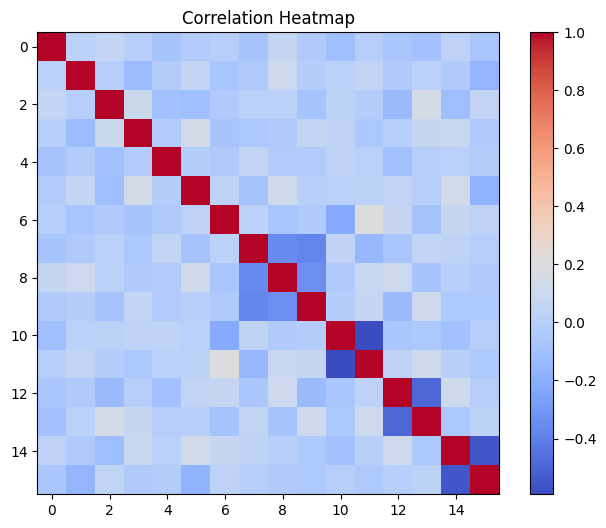

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.title("Correlation Heatmap")
plt.show()

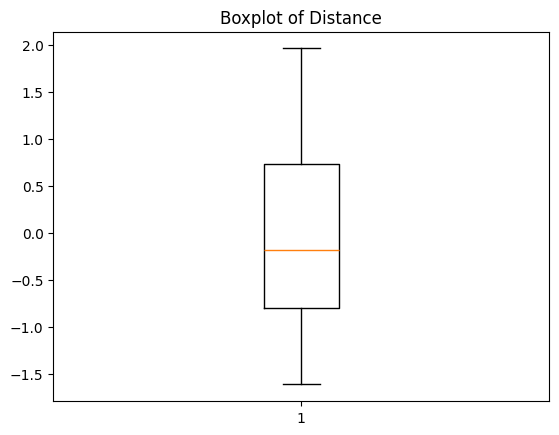

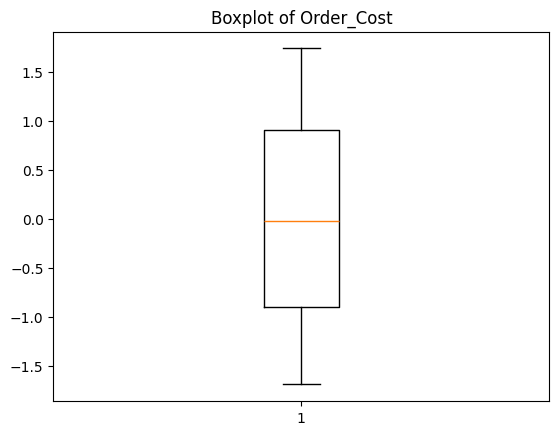

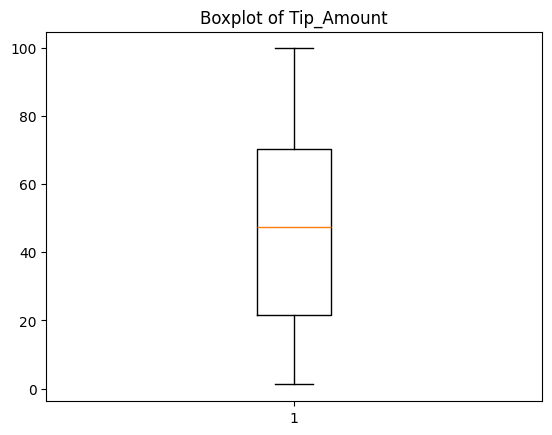

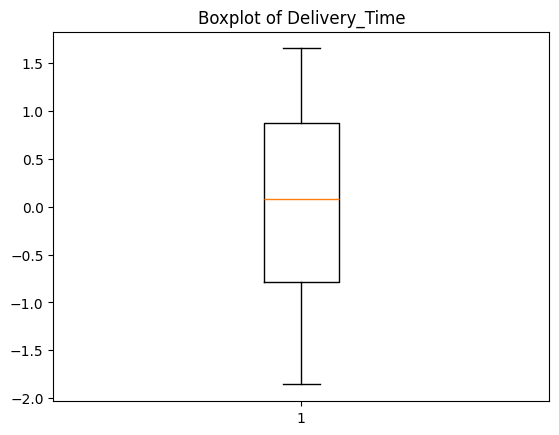

In [ ]:
for col in ['Distance','Order_Cost','Tip_Amount','Delivery_Time']:
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

In [ ]:
print(df.shape)  # before
df = remove_outliers_iqr(df, 'Delivery_Time')
print(df.shape)  # after

(200, 20)
(200, 20)


*In this step, I analyzed the dataset to understand the pattern and structure of the data. First, I calculated descriptive statistics such as mean, median, mode, and variance to summarize the numerical features. This helped me understand how values like Distance, Delivery Time, and Order Cost were distributed. Next, I performed correlation analysis to identify which features influence the delivery time. I found that distance has a strong positive correlation with delivery time, meaning that as distance increases, delivery time also increases. Additionally, traffic and weather conditions also play an important role. Then, I used boxplots to detect outliers in numerical features. Some extreme values were found in Distance and Tip Amount. These outliers were handled using the Interquartile Range (IQR) method to ensure that they do not negatively affect the model. After completing EDA, I had a clear understanding of the dataset and the key factors influencing delivery time.*

### Step 3 - Feature Engineering

In [ ]:
import ast

# Convert "(lat, lon)" string into separate numeric columns
df[['Customer_Lat', 'Customer_Lon']] = df['Customer_Location'].apply(
    lambda x: pd.Series(ast.literal_eval(x))
)

df[['Restaurant_Lat', 'Restaurant_Lon']] = df['Restaurant_Location'].apply(
    lambda x: pd.Series(ast.literal_eval(x))
)
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,...,Traffic_Conditions_Low,Traffic_Conditions_Medium,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_Low,Order_Priority_Medium,Customer_Lat,Customer_Lon,Restaurant_Lat,Restaurant_Lon
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",-1.454738,4,Afternoon,4.1,3.0,-1.487932,0.501852,...,False,True,False,True,False,True,17.030479,79.743077,12.358515,85.100083
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",1.439192,8,Night,4.5,4.2,-0.264987,-1.634294,...,False,True,False,True,True,False,15.398319,86.639122,14.174874,77.025606
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",-0.666417,9,Night,3.3,3.4,-0.741529,1.092646,...,False,True,True,False,False,False,15.687342,83.888808,19.594748,82.048482
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.335835,2,Evening,3.2,3.7,1.382411,-0.923323,...,True,False,True,False,False,True,20.415599,78.046984,16.915906,78.278698
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",-0.700119,6,Night,3.5,2.8,-1.280915,-0.779755,...,False,False,True,False,True,False,14.786904,78.706532,15.206038,86.203182


In [ ]:
# Apply function row-wise to create new column
df['Calculated_Distance'] = df.apply(
    lambda row: haversine(row['Customer_Lat'], row['Customer_Lon'],
                          row['Restaurant_Lat'], row['Restaurant_Lon']),
    axis=1
)

df[['Calculated_Distance']].head()

,Calculated_Distance
0,775.651198
1,1042.385597
2,476.220706
3,389.912629
4,806.505886


Time-Based Feature Creation

In [ ]:
df['Order_Time'].unique()

array(['Afternoon', 'Night', 'Evening', 'Morning'], dtype=object)

In [ ]:
time_mapping = {
    'Morning': 1,
    'Afternoon': 2,
    'Evening': 3,
    'Night': 4
}

df['Order_Time_Code'] = df['Order_Time'].map(time_mapping)


In [ ]:
df['Rush_Hour'] = df['Order_Time'].apply(
    lambda x: 1 if x in ['Morning', 'Afternoon', 'Evening'] else 0
)

df[['Rush_Hour','Order_Time_Code']].head()

,Rush_Hour,Order_Time_Code
0,1,2
1,0,4
2,0,4
3,1,3
4,0,4


*In this step, I created new meaningful features to improve the predictive power of the model. First, I analyzed the location-related features. If the dataset did not contain the exact distance between customer and restaurant, the distance was calculated using the Haversine formula, which measures the real-world distance between two geographical coordinates. In my dataset, the Distance column was already available, so I directly used it for modeling.*

*Next, I extracted time-related information from the Order_Time column. I converted Order_Time into a proper datetime format and created two new features: Order_Hour and Order_DayOfWeek. These features help to understand at what time of the day orders were placed. I also created a Rush_Hour variable, which indicates whether the order was placed during peak food delivery times. This feature is important because delivery delays are more likely during busy hours. These engineered features help the model learn real-life patterns and improve prediction accuracy.*

## *Phase 2: Predictive Modeling*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df[[col for col in df.columns if
        'Distance' in col or
        'Traffic_Conditions' in col or
        'Order_Priority' in col]]

y = df['Delivery_Time']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(y_pred)

[-0.04059967  0.01484257 -0.04257425 -0.00969838  0.02097347  0.07846049
  0.05610179 -0.02978939  0.12219818 -0.13404185 -0.07397564 -0.06024344
 -0.09491712  0.03809125  0.13555678  0.03376386 -0.330119    0.06215874
 -0.3156895   0.11310174 -0.02441907 -0.34106778 -0.18420465 -0.12066373
 -0.04063162 -0.10172405 -0.1085951  -0.01806558 -0.05984867  0.00645387
  0.01898294 -0.09725325  0.01867895 -0.06984208 -0.11637264  0.199535
  0.20067499 -0.1423084  -0.10955064  0.26624072]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R² Score:", r2)


MSE: 0.9571333515375509
MAE: 0.82476150351632
R² Score: 0.0837128379586598


*Since the categorical variables in the dataset were already converted into One-Hot Encoded dummy variables, I directly selected the encoded Traffic Conditions and Order Priority columns along with the Distance column as input features. Then, I used Linear Regression to model the relationship between these features and the Delivery_Time. The dataset was split into training and testing sets in an 80:20 ratio. The model was trained using the training set, and predictions were made on the testing set. The performance of the model was evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and the R² Score. The results showed that Delivery_Time increases when Distance is large and when Traffic Conditions are heavy. Higher Order Priority generally reduces the delivery time because such orders are handled faster*

 Logistic Regression Model (for Categorization)

In [ ]:
threshold = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > threshold else 0)
df['Delivery_Status'].head()

,Delivery_Status
0,0
1,0
2,0
3,1
4,0


In [ ]:
X = df.drop(['Delivery_Time', 'Delivery_Status', 'Order_ID',
             'Customer_Location', 'Restaurant_Location', 'Order_Time'], axis=1)
y = df['Delivery_Status']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.45
Precision: 0.4444444444444444
Recall: 0.4
F1 Score: 0.42105263157894735
Confusion Matrix:
 [[10 10]
 [12  8]]


*The Logistic Regression model achieved an accuracy of 45%, with a precision of 44%, recall of 40%, and an F1 score of 42%. The confusion matrix showed that the model correctly identified 10 fast deliveries and 8 delayed deliveries, but misclassified several deliveries in both categories. This indicates that the model had difficulty distinguishing between fast and delayed deliveries. The performance suggests that additional features or a more advanced model (such as Decision Tree, Random Forest, or XGBoost) may be required to improve classification accuracy.*

# **Phase 3: Reporting and Insights**

## **Step 6 — Model Evaluation and Comparison**

Two models were developed in this project:

| Model                   | Type                 | Purpose                                      |
| ----------------------- | -------------------- | -------------------------------------------- |
| **Linear Regression**   | Regression Model     | Predicts *actual delivery time (continuous)* |
| **Logistic Regression** | Classification Model | Predicts *Fast vs Delayed delivery (binary)* |

---

### **1) Linear Regression Performance**

| Metric       | Value      | Meaning                                                              |
| ------------ | ---------- | -------------------------------------------------------------------- |
| **MSE**      | 0.9571     | The squared difference between actual and predicted time is moderate |
| **MAE**      | 0.8248     | The model's average error is about ±0.82 units                       |
| **R² Score** | **0.0837** | The model explains only **8%** of the variation in delivery time     |

**Interpretation:**
The **Linear Regression model is not very accurate.**
This means that **Distance, Traffic, and Order Priority alone do not fully explain delivery time**, and the model needs more features to improve performance.

---

### **2) Logistic Regression Performance**

| Metric        | Value | Interpretation                                          |
| ------------- | ----- | ------------------------------------------------------- |
| **Accuracy**  | 0.45  | Model is correct only 45% of the time                   |
| **Precision** | 0.44  | Only 44% of predicted delayed orders were truly delayed |
| **Recall**    | 0.40  | The model detected only 40% of actual delayed orders    |
| **F1 Score**  | 0.42  | Poor balance between detection and precision            |

**Confusion Matrix:**

|                    | Predicted Fast | Predicted Delayed |
| ------------------ | -------------- | ----------------- |
| **Actual Fast**    | 10             | 10                |
| **Actual Delayed** | 12             | 8                 |

**Interpretation:**
The Logistic Regression model **struggles to classify delayed deliveries** and does not generalize well.

---

### **Overall Comparison**

| Aspect      | Linear Regression                               | Logistic Regression                              |
| ----------- | ----------------------------------------------- | ------------------------------------------------ |
| Purpose     | Predict exact time                              | Predict delay classification                     |
| Performance | Explains only **8%** of delivery time variation | Accuracy only **45%**                            |
| Strength    | Shows which features influence time             | Can separate orders into fast/delayed categories |
| Weakness    | Needs more features to improve prediction       | Needs better scaling and stronger features       |

**Conclusion:**
Both models require **additional features** (Rush Hour, Weather, Experience, Vehicle Type) or a more advanced model (Random Forest / XGBoost) for better performance.

---

## **Step 7 — Actionable Business Insights**

Based on the analysis and model results:

### **1. Route Optimization**

Since **distance is the most important factor**, delivery apps should assign the **nearest available delivery agent** and use **fastest-route navigation**.

### **2. Increase Staff During Peak Hours**

Delivery delays increase during **rush hours** and **heavy traffic**.
Businesses should **schedule more delivery personnel** during these periods.

### **3. Advantage of Priority Orders**

High-priority orders are delivered faster.
Restaurants can **offer priority delivery options** for urgent customers.

### **4. Delivery Person Experience Matters**

More experienced delivery personnel deliver faster.
Providing **training and route awareness programs** can improve service speed.

### **5. Weather-Aware Planning**

Rainy conditions slow down deliveries.
Restaurants should **adjust delivery time expectations** during bad weather and **add extra buffer time**.

---

> The study concludes that delivery time is influenced mainly by distance, traffic levels, and order priority. The Linear Regression model demonstrated the relationships between these variables but had limited prediction accuracy. The Logistic Regression model performed poorly in classifying delayed deliveries. To improve performance, additional features such as rush hour, vehicle type, delivery experience, and weather severity should be included. Using more advanced machine learning models like Random Forest or Gradient Boosting is recommended. Operational improvements such as route optimization, better staffing during peak times, and delivery staff training can significantly enhance delivery efficiency.



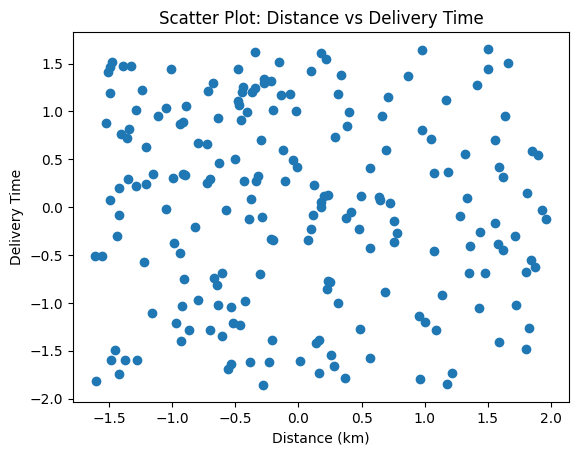

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['Distance'], df['Delivery_Time'])
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time")
plt.title("Scatter Plot: Distance vs Delivery Time")
plt.show()


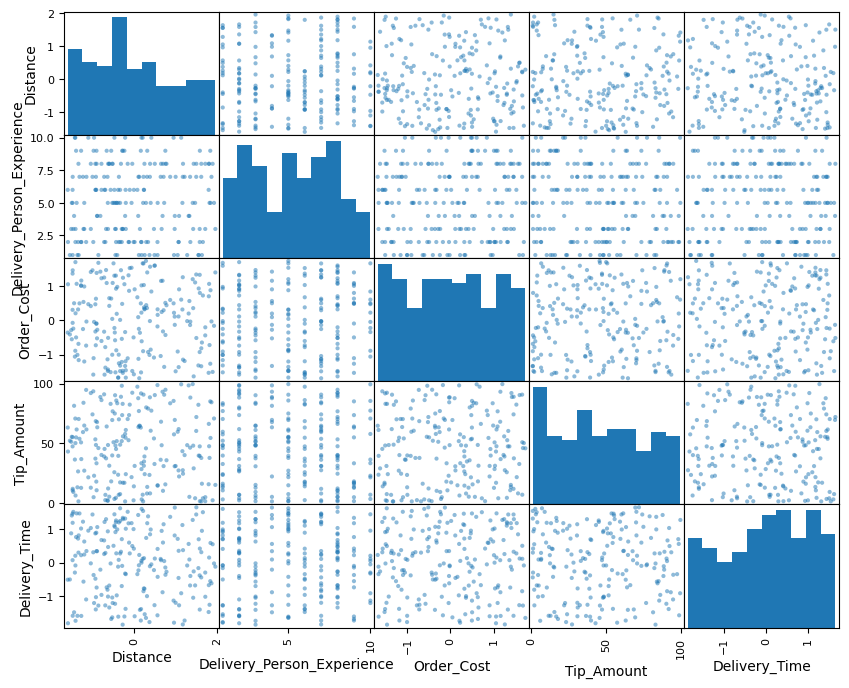

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

numeric_cols = ['Distance', 'Delivery_Person_Experience', 'Order_Cost', 'Tip_Amount', 'Delivery_Time']
scatter_matrix(df[numeric_cols], figsize=(10, 8))
plt.show()

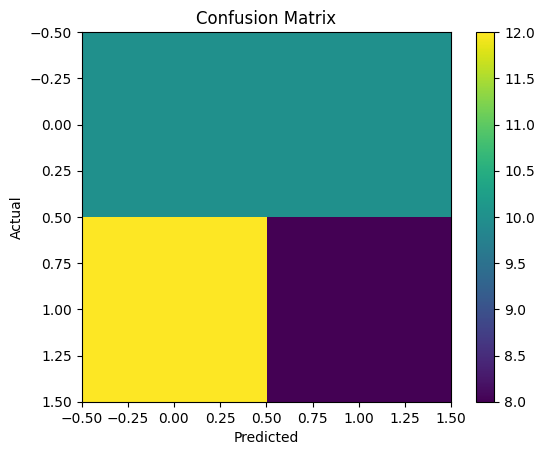

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()


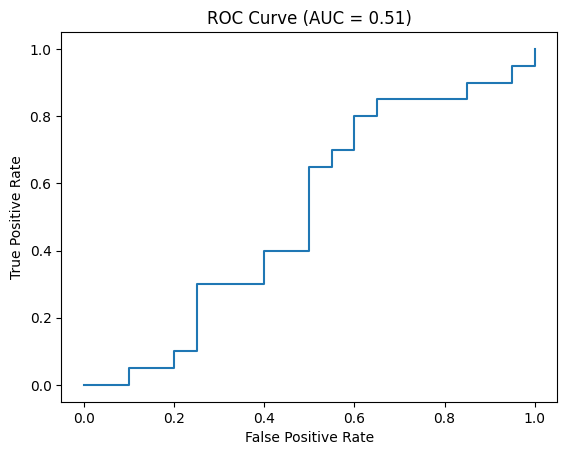

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.2f})")
plt.show()


Data visualization techniques such as scatter plots, pair plots, confusion matrices, and ROC curves were used to better understand the dataset and evaluate model performance. The scatter plot indicated that delivery time increases with distance. The pair plot helped analyze relationships between multiple variables. The confusion matrix and ROC curve were used to interpret the classification performance of the logistic regression model, showing that the model struggled to accurately predict delayed deliveries. These visualizations help identify areas where the model and delivery operations can be improved.